In [40]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [41]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [42]:
datos = np.log2(datos+1)

In [43]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [44]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [45]:
X_train = datos.loc[hkg].dropna()
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
idnT,6.061372,6.093678,6.077117,6.325967,6.015319,6.587866,6.507484,16.668359,16.724794
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799


In [46]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [47]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)
lower_hkg = q25 - 1.5*(q75 - q25)

In [48]:
cv_values

[0.047510330894395825,
 0.034282436941015654,
 0.5082800362135752,
 0.08274603355028991,
 0.07550553167722314,
 0.052812539574405244,
 0.1593059342197117,
 0.22872084846542823,
 0.2935911425658469,
 0.18868773605291764,
 0.19799310052122365,
 0.29599030526449727,
 0.03718694477894635,
 0.20738773919228934,
 0.044124249004606285,
 0.02402531796880816,
 0.03399753444494476,
 0.18407738946242252,
 0.20048677275570292,
 0.2707966507718216,
 0.4188544734596423]

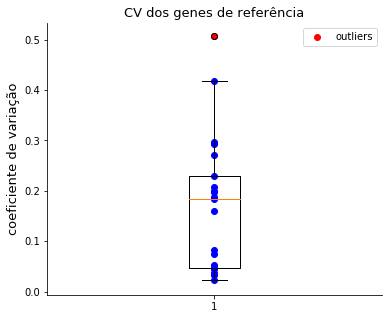

In [49]:
fig1 = plt.figure(figsize=(6,5))
i = 0
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("CV dos genes de referência", fontsize=13)
plt.ylabel("coeficiente de variação", fontsize=13)
for key in d_cv:
    if d_cv[key] <= upper_hkg and d_cv[key] >= lower_hkg:
        plt.scatter(1, d_cv[key], color="blue");
    else:
        plt.scatter(1, d_cv[key], color="red", label="outliers");
    i += 1
plt.boxplot(cv_values);
plt.legend();

In [50]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val > upper_hkg or val < lower_hkg:
        print(key, val)
        
#X_train = X_train.drop("idnT")
X_train.shape

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


(21, 9)

In [51]:
#X_train = X_train.drop("idnT")

In [52]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-0.999813,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959389,-1.000000,-1.000000,-1.000000,-1.000000
idnT,-0.946080,-0.948025,-0.944276,-0.914840,-1.000000,-0.930703,-0.942743,0.562604,0.575625
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.154926,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044301,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266177,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265186,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985678,0.886011,-0.662111,0.593895,0.772322


In [53]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [54]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18


In [55]:
G.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                950       
_________________________________________________________________
dense_13 (Dense)             (None, 150)               7650      
_________________________________________________________________
dense_14 (Dense)             (None, 9)                 1359      
_________________________________________________________________
reshape_2 (Reshape)          (None, 9)                 0         
Total params: 9,959
Trainable params: 9,959
Non-trainable params: 0
_________________________________________________________________


In [56]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (21, 18)
Dimension de los ejemplos generados: (21, 9)


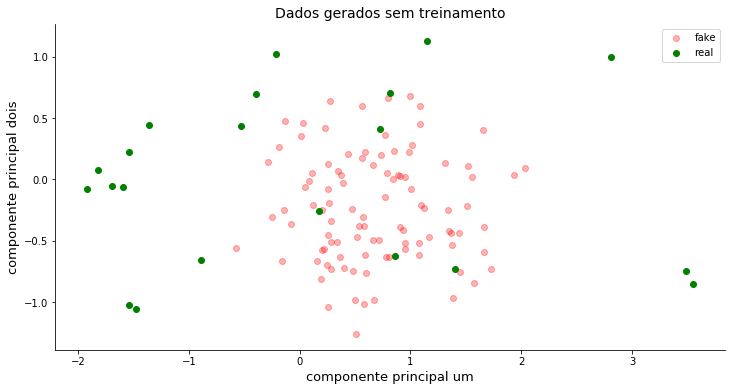

In [57]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(100, noise_input))
fig1 = plt.figure(figsize=(12,6))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="fake", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1)
plt.legend();

In [58]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [59]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

(21, 2) (63, 2)


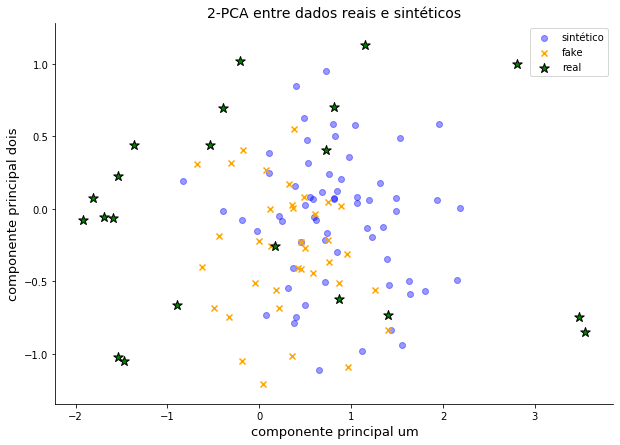

In [60]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(100, noise_input)))
sint = x_noise[np.where(D.predict_classes(x_noise)==1)[0],:]
fake = x_noise[np.where(D.predict_classes(x_noise)==0)[0],:]
X_sint_pca = pca_real.transform(sint)
X_fake_pca = pca_real.transform(fake)
print(X_train_pca.shape, X_sint_pca.shape)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="blue", label="sintético",alpha=.4)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="orange", marker="x",label="fake",alpha=1)

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [61]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [62]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [272]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=12, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (12, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((12,1)), np.zeros((12,1))))
        y_predict = D.predict_classes(X_test)
        f1_lag = f1_score(y_test, y_predict)
        fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss, fscore

In [273]:
noise_input = 7
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.92, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  7
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_61 (Sequential)   (None, 9)                 9409      
_________________________________________________________________
sequential_62 (Sequential)   (None, 1)                 1409      
Total params: 10,818
Trainable params: 9,409
Non-trainable params: 1,409
_________________________________________________________________


In [274]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.607314],[Generator::loss: 0.637487], 5.759531[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.620706],[Generator::loss: 0.705227], 0.014140[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.663464],[Generator::loss: 0.666805], 0.014308[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.624322],[Generator::loss: 0.606493], 0.015008[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.599133],[Generator::loss: 0.732128], 0.014097[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.638030],[Generator::loss: 0.694251], 0.014121[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.629123],[Generator::loss: 0.769256], 0.014147[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.640432],[Generator::loss: 0.703888], 0.014201[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.634407],[Generator::loss: 0.670545], 0.014949[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.606811],[Generator::loss: 0.662361], 0.014885[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.656940],[Generator::loss: 0.767042], 

epoch:[99/2000] [Discriminator::d_loss: 0.596599],[Generator::loss: 0.730303], 0.019767[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.586818],[Generator::loss: 0.720809], 0.023527[sec]
epoch:[101/2000] [Discriminator::d_loss: 0.588294],[Generator::loss: 0.728803], 0.020621[sec]
epoch:[102/2000] [Discriminator::d_loss: 0.603952],[Generator::loss: 0.757100], 0.015759[sec]
epoch:[103/2000] [Discriminator::d_loss: 0.574823],[Generator::loss: 0.673731], 0.015392[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.581941],[Generator::loss: 0.712236], 0.015246[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.578487],[Generator::loss: 0.731463], 0.015344[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.580706],[Generator::loss: 0.697247], 0.015477[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.592744],[Generator::loss: 0.750287], 0.015249[sec]
epoch:[108/2000] [Discriminator::d_loss: 0.587567],[Generator::loss: 0.709763], 0.016417[sec]
epoch:[109/2000] [Discriminator::d_loss: 0.606417],[Generator

epoch:[195/2000] [Discriminator::d_loss: 0.537635],[Generator::loss: 0.744576], 0.014585[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.568271],[Generator::loss: 0.733650], 0.017529[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.569085],[Generator::loss: 0.741554], 0.018247[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.563352],[Generator::loss: 0.740730], 0.014509[sec]
epoch:[199/2000] [Discriminator::d_loss: 0.562365],[Generator::loss: 0.751125], 0.014446[sec]
epoch:[200/2000] [Discriminator::d_loss: 0.564925],[Generator::loss: 0.732394], 0.014080[sec]
epoch:[201/2000] [Discriminator::d_loss: 0.562906],[Generator::loss: 0.745165], 0.014100[sec]
epoch:[202/2000] [Discriminator::d_loss: 0.554224],[Generator::loss: 0.742649], 0.014065[sec]
epoch:[203/2000] [Discriminator::d_loss: 0.559175],[Generator::loss: 0.742569], 0.014476[sec]
epoch:[204/2000] [Discriminator::d_loss: 0.557349],[Generator::loss: 0.757716], 0.013899[sec]
epoch:[205/2000] [Discriminator::d_loss: 0.547840],[Generato

epoch:[284/2000] [Discriminator::d_loss: 0.534454],[Generator::loss: 0.753570], 0.013798[sec]
epoch:[285/2000] [Discriminator::d_loss: 0.562294],[Generator::loss: 0.754674], 0.016362[sec]
epoch:[286/2000] [Discriminator::d_loss: 0.524221],[Generator::loss: 0.834182], 0.017663[sec]
epoch:[287/2000] [Discriminator::d_loss: 0.561355],[Generator::loss: 0.796839], 0.014586[sec]
epoch:[288/2000] [Discriminator::d_loss: 0.532372],[Generator::loss: 0.817432], 0.014161[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.553038],[Generator::loss: 0.751188], 0.014017[sec]
epoch:[290/2000] [Discriminator::d_loss: 0.551630],[Generator::loss: 0.814192], 0.014453[sec]
epoch:[291/2000] [Discriminator::d_loss: 0.550287],[Generator::loss: 0.790021], 0.014725[sec]
epoch:[292/2000] [Discriminator::d_loss: 0.538095],[Generator::loss: 0.792926], 0.017920[sec]
epoch:[293/2000] [Discriminator::d_loss: 0.539436],[Generator::loss: 0.734770], 0.015031[sec]
epoch:[294/2000] [Discriminator::d_loss: 0.533078],[Generato

epoch:[378/2000] [Discriminator::d_loss: 0.539388],[Generator::loss: 0.824294], 0.014917[sec]
epoch:[379/2000] [Discriminator::d_loss: 0.534185],[Generator::loss: 0.813520], 0.017682[sec]
epoch:[380/2000] [Discriminator::d_loss: 0.514668],[Generator::loss: 0.872135], 0.017050[sec]
epoch:[381/2000] [Discriminator::d_loss: 0.559481],[Generator::loss: 0.874634], 0.014339[sec]
epoch:[382/2000] [Discriminator::d_loss: 0.551536],[Generator::loss: 0.907343], 0.013964[sec]
epoch:[383/2000] [Discriminator::d_loss: 0.534304],[Generator::loss: 0.801674], 0.014051[sec]
epoch:[384/2000] [Discriminator::d_loss: 0.569431],[Generator::loss: 0.831637], 0.013869[sec]
epoch:[385/2000] [Discriminator::d_loss: 0.531585],[Generator::loss: 0.856532], 0.017239[sec]
epoch:[386/2000] [Discriminator::d_loss: 0.539223],[Generator::loss: 0.892606], 0.017567[sec]
epoch:[387/2000] [Discriminator::d_loss: 0.536520],[Generator::loss: 0.867718], 0.016360[sec]
epoch:[388/2000] [Discriminator::d_loss: 0.534725],[Generato

epoch:[473/2000] [Discriminator::d_loss: 0.550378],[Generator::loss: 0.907391], 0.015098[sec]
epoch:[474/2000] [Discriminator::d_loss: 0.530765],[Generator::loss: 0.991651], 0.021700[sec]
epoch:[475/2000] [Discriminator::d_loss: 0.530819],[Generator::loss: 0.887898], 0.014096[sec]
epoch:[476/2000] [Discriminator::d_loss: 0.542754],[Generator::loss: 0.954190], 0.014197[sec]
epoch:[477/2000] [Discriminator::d_loss: 0.524566],[Generator::loss: 0.870737], 0.014071[sec]
epoch:[478/2000] [Discriminator::d_loss: 0.573808],[Generator::loss: 1.006410], 0.014275[sec]
epoch:[479/2000] [Discriminator::d_loss: 0.532959],[Generator::loss: 0.930375], 0.013936[sec]
epoch:[480/2000] [Discriminator::d_loss: 0.561343],[Generator::loss: 0.913019], 0.013920[sec]
epoch:[481/2000] [Discriminator::d_loss: 0.537023],[Generator::loss: 0.945682], 0.013890[sec]
epoch:[482/2000] [Discriminator::d_loss: 0.561832],[Generator::loss: 0.937154], 0.014000[sec]
epoch:[483/2000] [Discriminator::d_loss: 0.514501],[Generato

epoch:[571/2000] [Discriminator::d_loss: 0.590103],[Generator::loss: 1.018967], 0.014214[sec]
epoch:[572/2000] [Discriminator::d_loss: 0.528330],[Generator::loss: 0.943797], 0.017232[sec]
epoch:[573/2000] [Discriminator::d_loss: 0.594829],[Generator::loss: 0.945423], 0.014870[sec]
epoch:[574/2000] [Discriminator::d_loss: 0.514315],[Generator::loss: 1.044748], 0.014382[sec]
epoch:[575/2000] [Discriminator::d_loss: 0.540004],[Generator::loss: 0.908609], 0.014179[sec]
epoch:[576/2000] [Discriminator::d_loss: 0.510458],[Generator::loss: 0.804620], 0.014035[sec]
epoch:[577/2000] [Discriminator::d_loss: 0.546323],[Generator::loss: 0.840356], 0.014143[sec]
epoch:[578/2000] [Discriminator::d_loss: 0.566453],[Generator::loss: 1.066772], 0.013817[sec]
epoch:[579/2000] [Discriminator::d_loss: 0.575056],[Generator::loss: 0.937177], 0.014710[sec]
epoch:[580/2000] [Discriminator::d_loss: 0.533590],[Generator::loss: 0.903978], 0.014081[sec]
epoch:[581/2000] [Discriminator::d_loss: 0.538481],[Generato

epoch:[667/2000] [Discriminator::d_loss: 0.642322],[Generator::loss: 0.770567], 0.019276[sec]
epoch:[668/2000] [Discriminator::d_loss: 0.586931],[Generator::loss: 0.979197], 0.017992[sec]
epoch:[669/2000] [Discriminator::d_loss: 0.614630],[Generator::loss: 0.885711], 0.014237[sec]
epoch:[670/2000] [Discriminator::d_loss: 0.640191],[Generator::loss: 0.896789], 0.014036[sec]
epoch:[671/2000] [Discriminator::d_loss: 0.632900],[Generator::loss: 0.905678], 0.014191[sec]
epoch:[672/2000] [Discriminator::d_loss: 0.616228],[Generator::loss: 0.923097], 0.013703[sec]
epoch:[673/2000] [Discriminator::d_loss: 0.580355],[Generator::loss: 0.791124], 0.014313[sec]
epoch:[674/2000] [Discriminator::d_loss: 0.584677],[Generator::loss: 0.952058], 0.013896[sec]
epoch:[675/2000] [Discriminator::d_loss: 0.619515],[Generator::loss: 1.101203], 0.014190[sec]
epoch:[676/2000] [Discriminator::d_loss: 0.559744],[Generator::loss: 0.937043], 0.013937[sec]
epoch:[677/2000] [Discriminator::d_loss: 0.628904],[Generato

epoch:[765/2000] [Discriminator::d_loss: 0.641048],[Generator::loss: 0.881028], 0.015172[sec]
epoch:[766/2000] [Discriminator::d_loss: 0.640743],[Generator::loss: 0.747615], 0.019572[sec]
epoch:[767/2000] [Discriminator::d_loss: 0.616471],[Generator::loss: 0.759598], 0.014409[sec]
epoch:[768/2000] [Discriminator::d_loss: 0.660218],[Generator::loss: 0.812657], 0.014167[sec]
epoch:[769/2000] [Discriminator::d_loss: 0.635336],[Generator::loss: 0.829958], 0.014084[sec]
epoch:[770/2000] [Discriminator::d_loss: 0.615944],[Generator::loss: 0.850001], 0.013961[sec]
epoch:[771/2000] [Discriminator::d_loss: 0.702685],[Generator::loss: 0.819501], 0.014387[sec]
epoch:[772/2000] [Discriminator::d_loss: 0.618041],[Generator::loss: 0.986317], 0.013868[sec]
epoch:[773/2000] [Discriminator::d_loss: 0.671568],[Generator::loss: 0.715038], 0.014176[sec]
epoch:[774/2000] [Discriminator::d_loss: 0.609451],[Generator::loss: 0.937414], 0.014072[sec]
epoch:[775/2000] [Discriminator::d_loss: 0.586840],[Generato

epoch:[860/2000] [Discriminator::d_loss: 0.620683],[Generator::loss: 0.891204], 0.015120[sec]
epoch:[861/2000] [Discriminator::d_loss: 0.623504],[Generator::loss: 0.820872], 0.029600[sec]
epoch:[862/2000] [Discriminator::d_loss: 0.654632],[Generator::loss: 0.808876], 0.021621[sec]
epoch:[863/2000] [Discriminator::d_loss: 0.691044],[Generator::loss: 0.888319], 0.020549[sec]
epoch:[864/2000] [Discriminator::d_loss: 0.655785],[Generator::loss: 0.770489], 0.015005[sec]
epoch:[865/2000] [Discriminator::d_loss: 0.634004],[Generator::loss: 0.959342], 0.013994[sec]
epoch:[866/2000] [Discriminator::d_loss: 0.697632],[Generator::loss: 0.760406], 0.014260[sec]
epoch:[867/2000] [Discriminator::d_loss: 0.645983],[Generator::loss: 0.862602], 0.013888[sec]
epoch:[868/2000] [Discriminator::d_loss: 0.674529],[Generator::loss: 0.604385], 0.014443[sec]
epoch:[869/2000] [Discriminator::d_loss: 0.665432],[Generator::loss: 0.839476], 0.014036[sec]
epoch:[870/2000] [Discriminator::d_loss: 0.642159],[Generato

epoch:[956/2000] [Discriminator::d_loss: 0.708737],[Generator::loss: 0.783049], 0.015718[sec]
epoch:[957/2000] [Discriminator::d_loss: 0.716299],[Generator::loss: 0.769232], 0.020690[sec]
epoch:[958/2000] [Discriminator::d_loss: 0.764273],[Generator::loss: 0.695050], 0.014537[sec]
epoch:[959/2000] [Discriminator::d_loss: 0.673522],[Generator::loss: 0.678889], 0.014144[sec]
epoch:[960/2000] [Discriminator::d_loss: 0.676658],[Generator::loss: 0.701626], 0.013944[sec]
epoch:[961/2000] [Discriminator::d_loss: 0.766286],[Generator::loss: 0.673488], 0.013816[sec]
epoch:[962/2000] [Discriminator::d_loss: 0.718791],[Generator::loss: 0.782124], 0.013927[sec]
epoch:[963/2000] [Discriminator::d_loss: 0.739716],[Generator::loss: 0.745296], 0.013988[sec]
epoch:[964/2000] [Discriminator::d_loss: 0.674162],[Generator::loss: 0.866580], 0.014123[sec]
epoch:[965/2000] [Discriminator::d_loss: 0.681869],[Generator::loss: 0.788289], 0.014155[sec]
epoch:[966/2000] [Discriminator::d_loss: 0.672546],[Generato

epoch:[1054/2000] [Discriminator::d_loss: 0.765473],[Generator::loss: 0.822433], 0.015473[sec]
epoch:[1055/2000] [Discriminator::d_loss: 0.694626],[Generator::loss: 0.776204], 0.016689[sec]
epoch:[1056/2000] [Discriminator::d_loss: 0.741794],[Generator::loss: 0.681873], 0.014325[sec]
epoch:[1057/2000] [Discriminator::d_loss: 0.692904],[Generator::loss: 0.724017], 0.014190[sec]
epoch:[1058/2000] [Discriminator::d_loss: 0.728228],[Generator::loss: 0.782451], 0.014163[sec]
epoch:[1059/2000] [Discriminator::d_loss: 0.692996],[Generator::loss: 0.716823], 0.013949[sec]
epoch:[1060/2000] [Discriminator::d_loss: 0.703784],[Generator::loss: 0.806424], 0.014879[sec]
epoch:[1061/2000] [Discriminator::d_loss: 0.721986],[Generator::loss: 0.663985], 0.014155[sec]
epoch:[1062/2000] [Discriminator::d_loss: 0.732371],[Generator::loss: 0.741719], 0.013836[sec]
epoch:[1063/2000] [Discriminator::d_loss: 0.692458],[Generator::loss: 0.737534], 0.014077[sec]
epoch:[1064/2000] [Discriminator::d_loss: 0.729447

epoch:[1151/2000] [Discriminator::d_loss: 0.707774],[Generator::loss: 0.762546], 0.015660[sec]
epoch:[1152/2000] [Discriminator::d_loss: 0.711034],[Generator::loss: 0.854863], 0.015821[sec]
epoch:[1153/2000] [Discriminator::d_loss: 0.734896],[Generator::loss: 0.820900], 0.016381[sec]
epoch:[1154/2000] [Discriminator::d_loss: 0.738653],[Generator::loss: 0.750314], 0.015657[sec]
epoch:[1155/2000] [Discriminator::d_loss: 0.722228],[Generator::loss: 0.674219], 0.014521[sec]
epoch:[1156/2000] [Discriminator::d_loss: 0.725104],[Generator::loss: 0.667476], 0.015264[sec]
epoch:[1157/2000] [Discriminator::d_loss: 0.681348],[Generator::loss: 0.811273], 0.014270[sec]
epoch:[1158/2000] [Discriminator::d_loss: 0.696252],[Generator::loss: 0.846976], 0.014310[sec]
epoch:[1159/2000] [Discriminator::d_loss: 0.756181],[Generator::loss: 0.764167], 0.014179[sec]
epoch:[1160/2000] [Discriminator::d_loss: 0.743671],[Generator::loss: 0.771492], 0.014517[sec]
epoch:[1161/2000] [Discriminator::d_loss: 0.693228

epoch:[1248/2000] [Discriminator::d_loss: 0.704727],[Generator::loss: 0.688991], 0.016630[sec]
epoch:[1249/2000] [Discriminator::d_loss: 0.724474],[Generator::loss: 0.780117], 0.016383[sec]
epoch:[1250/2000] [Discriminator::d_loss: 0.738160],[Generator::loss: 0.761445], 0.014450[sec]
epoch:[1251/2000] [Discriminator::d_loss: 0.702413],[Generator::loss: 0.763218], 0.014247[sec]
epoch:[1252/2000] [Discriminator::d_loss: 0.689355],[Generator::loss: 0.733490], 0.014107[sec]
epoch:[1253/2000] [Discriminator::d_loss: 0.740401],[Generator::loss: 0.692681], 0.014095[sec]
epoch:[1254/2000] [Discriminator::d_loss: 0.708627],[Generator::loss: 0.788235], 0.014274[sec]
epoch:[1255/2000] [Discriminator::d_loss: 0.737894],[Generator::loss: 0.854729], 0.014260[sec]
epoch:[1256/2000] [Discriminator::d_loss: 0.699016],[Generator::loss: 0.719253], 0.013884[sec]
epoch:[1257/2000] [Discriminator::d_loss: 0.723041],[Generator::loss: 0.726417], 0.014176[sec]
epoch:[1258/2000] [Discriminator::d_loss: 0.657222

epoch:[1342/2000] [Discriminator::d_loss: 0.688477],[Generator::loss: 0.815909], 0.018254[sec]
epoch:[1343/2000] [Discriminator::d_loss: 0.682560],[Generator::loss: 0.834128], 0.016775[sec]
epoch:[1344/2000] [Discriminator::d_loss: 0.706138],[Generator::loss: 0.796353], 0.015740[sec]
epoch:[1345/2000] [Discriminator::d_loss: 0.690889],[Generator::loss: 0.761865], 0.015196[sec]
epoch:[1346/2000] [Discriminator::d_loss: 0.684217],[Generator::loss: 0.729691], 0.014902[sec]
epoch:[1347/2000] [Discriminator::d_loss: 0.698254],[Generator::loss: 0.754998], 0.015774[sec]
epoch:[1348/2000] [Discriminator::d_loss: 0.714042],[Generator::loss: 0.855306], 0.014970[sec]
epoch:[1349/2000] [Discriminator::d_loss: 0.673091],[Generator::loss: 0.719345], 0.015919[sec]
epoch:[1350/2000] [Discriminator::d_loss: 0.712995],[Generator::loss: 0.746385], 0.015692[sec]
epoch:[1351/2000] [Discriminator::d_loss: 0.686427],[Generator::loss: 0.795793], 0.014319[sec]
epoch:[1352/2000] [Discriminator::d_loss: 0.710716

epoch:[1438/2000] [Discriminator::d_loss: 0.650161],[Generator::loss: 0.691145], 0.016628[sec]
epoch:[1439/2000] [Discriminator::d_loss: 0.730412],[Generator::loss: 0.764124], 0.022308[sec]
epoch:[1440/2000] [Discriminator::d_loss: 0.664738],[Generator::loss: 0.815071], 0.015908[sec]
epoch:[1441/2000] [Discriminator::d_loss: 0.700842],[Generator::loss: 0.716118], 0.015327[sec]
epoch:[1442/2000] [Discriminator::d_loss: 0.684168],[Generator::loss: 0.693785], 0.015181[sec]
epoch:[1443/2000] [Discriminator::d_loss: 0.654967],[Generator::loss: 0.745712], 0.015944[sec]
epoch:[1444/2000] [Discriminator::d_loss: 0.750611],[Generator::loss: 0.765665], 0.015057[sec]
epoch:[1445/2000] [Discriminator::d_loss: 0.739109],[Generator::loss: 0.754719], 0.014362[sec]
epoch:[1446/2000] [Discriminator::d_loss: 0.724703],[Generator::loss: 0.729227], 0.014661[sec]
epoch:[1447/2000] [Discriminator::d_loss: 0.684228],[Generator::loss: 0.774615], 0.014533[sec]
epoch:[1448/2000] [Discriminator::d_loss: 0.658737

epoch:[1533/2000] [Discriminator::d_loss: 0.715209],[Generator::loss: 0.704204], 0.015403[sec]
epoch:[1534/2000] [Discriminator::d_loss: 0.670892],[Generator::loss: 0.799544], 0.016940[sec]
epoch:[1535/2000] [Discriminator::d_loss: 0.656849],[Generator::loss: 0.674557], 0.015614[sec]
epoch:[1536/2000] [Discriminator::d_loss: 0.652779],[Generator::loss: 0.718077], 0.017253[sec]
epoch:[1537/2000] [Discriminator::d_loss: 0.670685],[Generator::loss: 0.757344], 0.014879[sec]
epoch:[1538/2000] [Discriminator::d_loss: 0.685111],[Generator::loss: 0.781309], 0.014958[sec]
epoch:[1539/2000] [Discriminator::d_loss: 0.661815],[Generator::loss: 0.728690], 0.016791[sec]
epoch:[1540/2000] [Discriminator::d_loss: 0.719428],[Generator::loss: 0.727457], 0.017383[sec]
epoch:[1541/2000] [Discriminator::d_loss: 0.699020],[Generator::loss: 0.802716], 0.015109[sec]
epoch:[1542/2000] [Discriminator::d_loss: 0.677089],[Generator::loss: 0.814879], 0.014647[sec]
epoch:[1543/2000] [Discriminator::d_loss: 0.687886

epoch:[1630/2000] [Discriminator::d_loss: 0.678053],[Generator::loss: 0.778238], 0.015896[sec]
epoch:[1631/2000] [Discriminator::d_loss: 0.687581],[Generator::loss: 0.728861], 0.016325[sec]
epoch:[1632/2000] [Discriminator::d_loss: 0.700077],[Generator::loss: 0.719115], 0.014447[sec]
epoch:[1633/2000] [Discriminator::d_loss: 0.671737],[Generator::loss: 0.720387], 0.013906[sec]
epoch:[1634/2000] [Discriminator::d_loss: 0.668943],[Generator::loss: 0.772673], 0.014238[sec]
epoch:[1635/2000] [Discriminator::d_loss: 0.664840],[Generator::loss: 0.807341], 0.013654[sec]
epoch:[1636/2000] [Discriminator::d_loss: 0.701166],[Generator::loss: 0.728417], 0.014131[sec]
epoch:[1637/2000] [Discriminator::d_loss: 0.653998],[Generator::loss: 0.808414], 0.014105[sec]
epoch:[1638/2000] [Discriminator::d_loss: 0.685887],[Generator::loss: 0.740732], 0.014325[sec]
epoch:[1639/2000] [Discriminator::d_loss: 0.663511],[Generator::loss: 0.828312], 0.014072[sec]
epoch:[1640/2000] [Discriminator::d_loss: 0.648884

epoch:[1723/2000] [Discriminator::d_loss: 0.666903],[Generator::loss: 0.796795], 0.014075[sec]
epoch:[1724/2000] [Discriminator::d_loss: 0.667013],[Generator::loss: 0.737582], 0.017197[sec]
epoch:[1725/2000] [Discriminator::d_loss: 0.669488],[Generator::loss: 0.761492], 0.014562[sec]
epoch:[1726/2000] [Discriminator::d_loss: 0.699512],[Generator::loss: 0.737454], 0.014293[sec]
epoch:[1727/2000] [Discriminator::d_loss: 0.701970],[Generator::loss: 0.745398], 0.014091[sec]
epoch:[1728/2000] [Discriminator::d_loss: 0.699094],[Generator::loss: 0.774489], 0.014170[sec]
epoch:[1729/2000] [Discriminator::d_loss: 0.664802],[Generator::loss: 0.789320], 0.014219[sec]
epoch:[1730/2000] [Discriminator::d_loss: 0.632398],[Generator::loss: 0.777294], 0.014223[sec]
epoch:[1731/2000] [Discriminator::d_loss: 0.703856],[Generator::loss: 0.722727], 0.013748[sec]
epoch:[1732/2000] [Discriminator::d_loss: 0.636902],[Generator::loss: 0.737974], 0.014141[sec]
epoch:[1733/2000] [Discriminator::d_loss: 0.692987

epoch:[1818/2000] [Discriminator::d_loss: 0.682303],[Generator::loss: 0.681452], 0.014992[sec]
epoch:[1819/2000] [Discriminator::d_loss: 0.682861],[Generator::loss: 0.775050], 0.017718[sec]
epoch:[1820/2000] [Discriminator::d_loss: 0.648142],[Generator::loss: 0.662877], 0.014849[sec]
epoch:[1821/2000] [Discriminator::d_loss: 0.708548],[Generator::loss: 0.782534], 0.014242[sec]
epoch:[1822/2000] [Discriminator::d_loss: 0.676772],[Generator::loss: 0.749694], 0.014848[sec]
epoch:[1823/2000] [Discriminator::d_loss: 0.665777],[Generator::loss: 0.766514], 0.014004[sec]
epoch:[1824/2000] [Discriminator::d_loss: 0.671807],[Generator::loss: 0.795004], 0.014079[sec]
epoch:[1825/2000] [Discriminator::d_loss: 0.710280],[Generator::loss: 0.714281], 0.013848[sec]
epoch:[1826/2000] [Discriminator::d_loss: 0.714657],[Generator::loss: 0.794613], 0.013898[sec]
epoch:[1827/2000] [Discriminator::d_loss: 0.658819],[Generator::loss: 0.765270], 0.014169[sec]
epoch:[1828/2000] [Discriminator::d_loss: 0.686770

epoch:[1907/2000] [Discriminator::d_loss: 0.662974],[Generator::loss: 0.788988], 0.033848[sec]
epoch:[1908/2000] [Discriminator::d_loss: 0.689368],[Generator::loss: 0.771951], 0.023403[sec]
epoch:[1909/2000] [Discriminator::d_loss: 0.660662],[Generator::loss: 0.791162], 0.018126[sec]
epoch:[1910/2000] [Discriminator::d_loss: 0.647902],[Generator::loss: 0.688809], 0.015890[sec]
epoch:[1911/2000] [Discriminator::d_loss: 0.667153],[Generator::loss: 0.703999], 0.015105[sec]
epoch:[1912/2000] [Discriminator::d_loss: 0.686858],[Generator::loss: 0.782741], 0.013824[sec]
epoch:[1913/2000] [Discriminator::d_loss: 0.665520],[Generator::loss: 0.716340], 0.014122[sec]
epoch:[1914/2000] [Discriminator::d_loss: 0.678702],[Generator::loss: 0.731827], 0.014366[sec]
epoch:[1915/2000] [Discriminator::d_loss: 0.679933],[Generator::loss: 0.761275], 0.013799[sec]
epoch:[1916/2000] [Discriminator::d_loss: 0.659156],[Generator::loss: 0.824938], 0.014279[sec]
epoch:[1917/2000] [Discriminator::d_loss: 0.694942

epoch:[2000/2000] [Discriminator::d_loss: 0.679823],[Generator::loss: 0.693854], 0.017100[sec]


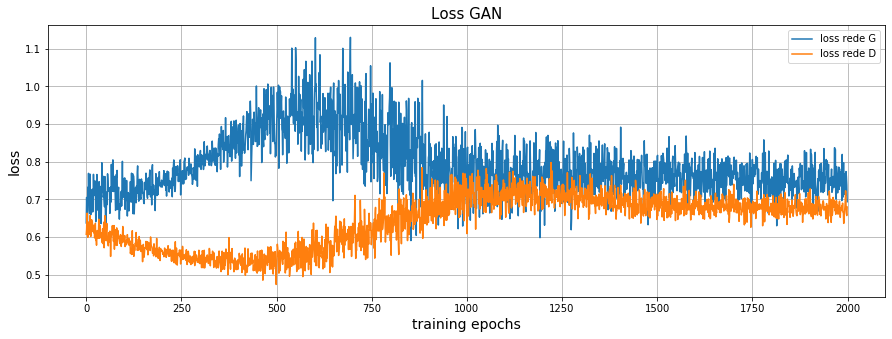

In [276]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

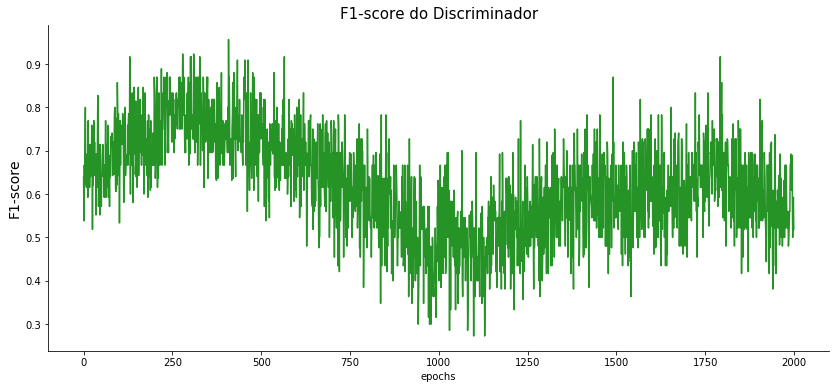

In [277]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(21, 2) (300, 2)


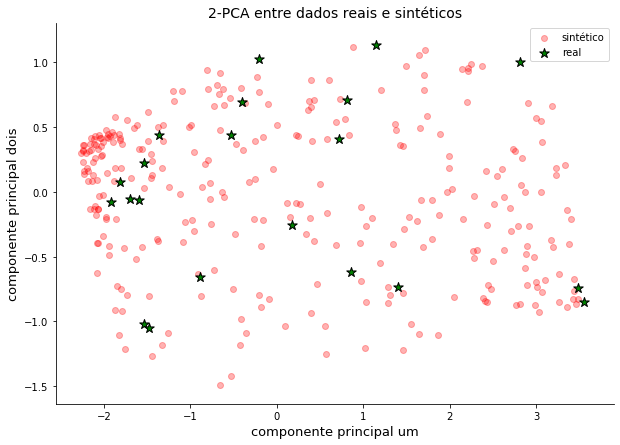

In [278]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

(21, 2) (1221, 2)


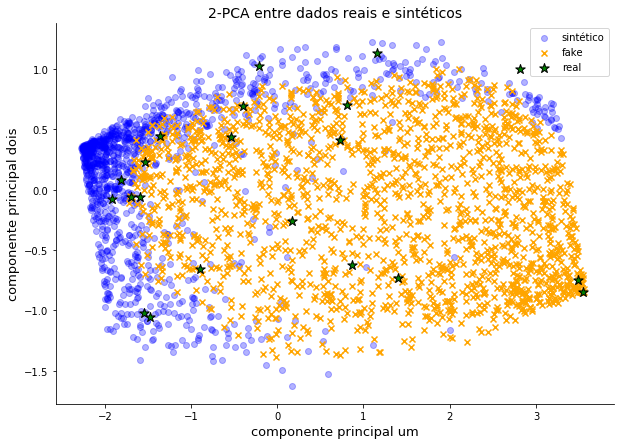

In [279]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(3000, noise_input)))
sint = x_noise[np.where(D.predict_classes(x_noise)==1)[0],:]
fake = x_noise[np.where(D.predict_classes(x_noise)==0)[0],:]
X_sint_pca = pca_real.transform(sint)
X_fake_pca = pca_real.transform(fake)
print(X_train_pca.shape, X_sint_pca.shape)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="blue", label="sintético",alpha=0.3)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="orange", marker="x",label="fake",alpha=1)

plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [284]:
np.mean(D.predict_classes(X_train))

0.5714285714285714

In [283]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964066,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060696,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.077810,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425654,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996595,-0.974946,-0.973578,-0.897515,-0.892211


(21, 2) (4293, 2)


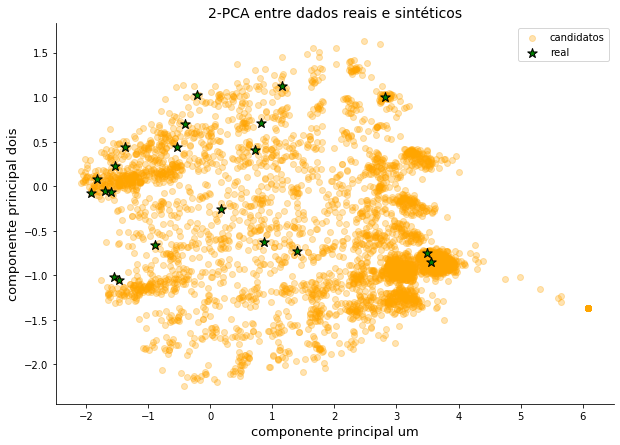

In [288]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
X_cand = pca_real.transform(datos)
print(X_train_pca.shape, X_cand.shape)
plt.scatter(X_cand[:,0], X_cand[:,1], color="orange", label="candidatos",alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

0.5714285714285714

### CV dos genes gerados

In [251]:
maxt = max_train.values.reshape(1,9)
mint = min_train.values.reshape(1,9)
x_sint = (0.5*(maxt-mint)*(x_noise+1))+mint
x_sint.shape

(300, 9)

In [252]:
lower_hkg, upper_hkg

(-0.2243054454621528, 0.5005366248219769)

In [253]:
cv_sint = []
for i in range(x_sint.shape[0]):
    cv_sint.append(np.std(x_sint[i,:])/np.mean(x_sint[i,:]))

In [254]:
sum(cv_sint > upper_hkg) + sum(cv_sint < lower_hkg)

0

In [255]:
X_rg = (0.5*(maxt-mint)*(X_train+1))+mint
X_rg.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
idnT,6.061372,6.093678,6.077117,6.325967,6.015319,6.587866,6.507484,16.668359,16.724794
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441


In [256]:
X_rg.values.shape, x_sint.shape

((21, 9), (300, 9))

In [257]:
x_sint = pd.DataFrame(x_sint, columns=X_rg.columns)
x_sint.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
0,16.626237,18.721950,9.386072,18.570357,17.017882,16.949049,17.817059,19.644159,19.220560
1,10.812524,9.430908,17.598397,15.591373,13.196896,8.972196,11.433678,9.931820,15.122809
2,18.485721,19.305844,17.750327,18.762820,13.322807,16.998919,19.716525,19.678552,19.590871
3,14.520671,17.791498,17.205115,19.201092,18.317686,15.185125,16.482418,19.052914,18.789646
4,8.115024,7.575415,7.355519,9.792020,10.977714,11.356534,7.719586,7.637475,10.351017


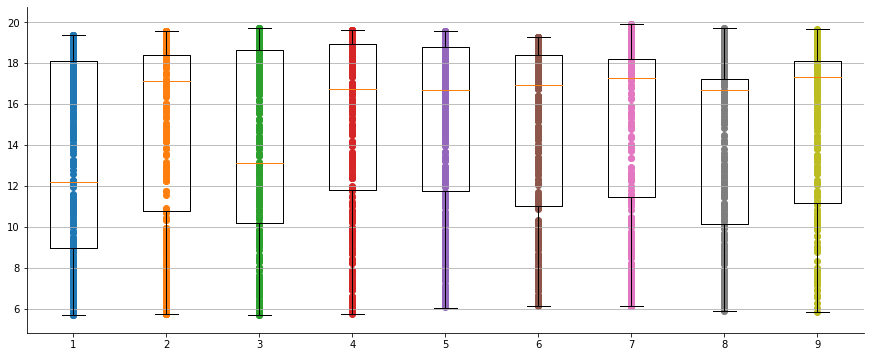

In [258]:
fig2 = plt.figure(figsize=(15,6))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.yaxis.grid()
plt.boxplot(X_rg.values);
for i in range(x_sint.shape[1]):
    plt.scatter(np.ones(x_sint.shape[0])*(i+1), x_sint.iloc[:,i])

In [208]:
x_sint["class"] = 0
x_sint.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18,class
0,15.139376,16.999601,8.188356,18.253122,19.019527,17.724830,14.429442,6.628400,11.923949,0
1,12.143121,16.302813,13.991911,17.539113,15.768236,14.301520,16.781814,14.987245,15.439850,0
2,5.947489,5.999720,6.662953,7.200574,6.199984,6.354030,7.163629,16.515043,12.617016,0
3,7.603006,8.808065,7.540218,13.856253,11.123951,9.068497,9.916926,12.542585,14.270291,0
4,7.391268,9.020385,14.841306,10.623469,6.860164,6.515018,14.442783,19.322398,16.361107,0


In [209]:
X_rg["class"] = 1

## parallel coordinates

In [210]:
data_p = pd.concat([X_rg, x_sint])

In [211]:
data_p.columns[:-1]

Index(['BB9', 'BB10', 'BB17', 'BB19', 'BB20', 'BB21', 'BB11', 'BB12', 'BB18'], dtype='object')

In [212]:
pa_dim = list()
for i in data_p.columns[:-1]:
    d = dict()
    d["range"] = [5,20]
    d["label"] = i
    d["values"] = data_p[i].values
    pa_dim.append(d)

In [214]:
import plotly.graph_objects as go

fig = go.Figure(data=
    go.Parcoords(
        line = dict(color = data_p['class'], colorscale = [[0,'orange'],[1,'green']]),
        dimensions = pa_dim))

fig.update_layout(
    plot_bgcolor = 'white',
    paper_bgcolor = 'white'
)

fig.show()